## Example Notebook of using Bayesian Inference in MAPS using square-root spherical harmonics 
First let's import the necessary packages

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sys, os
sys.path.append("../../maps/")
import anis_pta as ap
import utils
import numpy.random as rn
from enterprise.signals import anis_coefficients as ac
import bilby
import pandas as pd
import pickle, corner
from la_forge import core, diagnostics

Optional mpi4py package is not installed.  MPI support is not available.


/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


## Simulate data

In MAPS, we consider amplitude scaled pulsar pairs cross-correlations ($\rho$) as our data. This can be modelled by the detector Overlap Reduction Function (ORF) given as $\Gamma = A (R \cdot P)$. Where, $A$ is the amplitude correction parameter.

In this example, to simulate $\Gamma$, first we define 67 pulsars uniformly distributed accross the sky, $nside$ defining the no. of pixel tessellation of the healpix sky (and hence no. of pixels in the sky), $l_{max}$ defining the maximum angular resolution of the sky to use for spherical harmonics representation.

In [2]:
### Create a random draw generator with a seed
rng = rn.default_rng(seed=316)

In [3]:
npsrs = 67
nside = 8
l_max = 6
nblm = int((l_max/2+1)**2)

ncc = int(npsrs*(npsrs-1)/2)

print(f"Using {npsrs} pulsars with {ncc} pairs.")
print(f"Using {l_max} lmax with {nblm} blm parameters.")

Using 67 pulsars with 2211 pairs.
Using 6 lmax with 16 blm parameters.


In [4]:
#Draw random uniform positions for pulsars in PTA
psrs_phi = rng.uniform(low = 0, high = 2 * np.pi, size = npsrs)
psrs_theta = np.arccos(1 - 2 * rng.uniform(0, 1, size = npsrs))

Now, initiate a PTA object without correlation values to gain access to some useful functions. Note that we can set data afterwards. Here, we define the basis in which we search for anisotropy. In this example, we use 'sqrt_power_basis' which is the square-root spherical harmonics basis.

In [5]:
pta = ap.anis_pta(psrs_theta, psrs_phi, nside = nside, l_max = l_max, mode = 'sqrt_power_basis')

/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/enterprise/signals/anis_coefficients.py:194: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  h = hp.alm2map(alm, nside, maxl, verbose=False)


Some of the important functions that this sets up are: the response matrix $R$ of shape ($N_{cross-correlations} \times N_{pix}$), real-valued spherical harmonics $Y_{lm}(\theta, \phi)$ of shape ($N_{clm} \times N_{pix}$) and hence $\Gamma_{lm} = Y_{lm} \cdot R^{T}$ of shape ($N_{clm} \times N_{cross-correlations}$).

### Inject anisotropy

In this example, we can create injections using $2$ methods.

1. Adding a hotspot to an isotropic background: 
       We generate this as individual pixel powers. For an isotropic background, we can supply a pixel vector of all 1, meaning even power throughout the sky. On top of this, select a circular area on the sky at ($\theta$, $\phi$) for which we increase the power. We then combine this simulated map of shape ($N_{pix}$) with $R$ to create the injected data. 

2. With $b_{lm}$ values: 
       We generate random $b_{lm}$ values with $b_{00}=1$. Then we convert $b_{lm}$'s to $c_{lm}$'s and finally combine it with $\Gamma_{lm}$ to create the injected data.

Note that while MAPS does support pair covariance, this example will not use it.

Here, we use method $1$ and use a handy function in utils: ``` utils.inject_anisotropy(pta, method, **arg) ```. Here, all **arg are optional. This function creates the <span style="color:blue">injection</span> attributes of anis_pta instance/object. <span style="color:blue">pta.injected_rho</span>, <span style="color:blue">pta.injected_sig</span>, and <span style="color:blue">pta.injected_pair_cov</span> contains the injected cross_correlations ($\rho$) data, $1-d$ uncertainties on $\rho$, and diagonal pair-covariance matrix (None if not supplied) respectively. 

* With method 1, <span style="color:blue">pta.injected_power</span>, and <span style="color:blue">pta.injected_Cl</span> contains an array of injected pixel power, and angular power spectrum respectively which is very handy for post processing.

* With method 2, <span style="color:blue">pta.injected_blms</span>, <span style="color:blue">pta.injected_power</span>, and <span style="color:blue">pta.injected_Cl</span> contains an array of injected $b_{lm}$'s, pixel power, and angular power spectrum respectively which is very handy for post processing.

In [6]:
### One can add random noise using add_rand_noise=True 
### which adds gaussian noise scaled by sim_sig

### For method 1:
utils.inject_anisotropy(pta, method='pixel', sim_log10_A2=0.0, sim_power=50, sim_theta=np.pi/3, sim_phi=np.pi/2, lonlat=False, 
                        sim_pixel_radius=10, sim_sig=0.1, pair_cov=False, return_vals=False, add_rand_noise=False)

### For method 2:
### Note that we can supply a list of blm value to inject using sim_blms.
### If it's None then the values are randomly generated internally with seed=seed (optional).
#utils.inject_anisotropy(pta, method='sqrt_power_basis', seed=seed)

Let's look at the injection in the skymap and ORF representation.

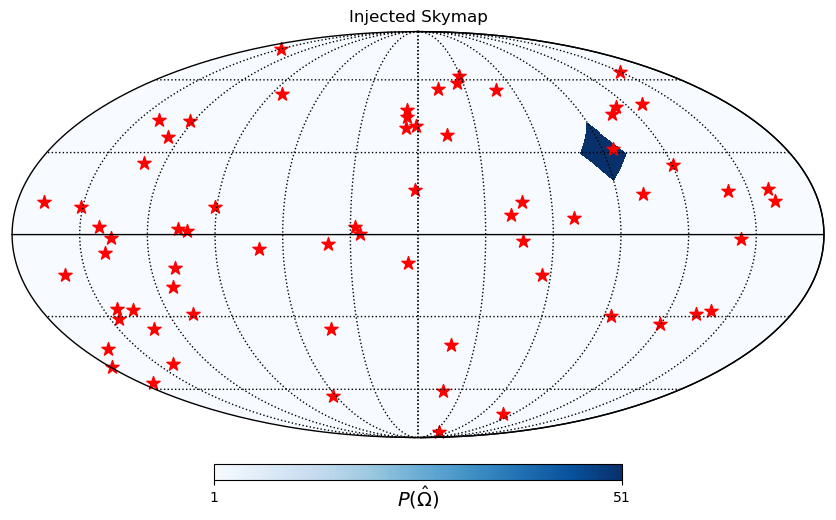

In [7]:
# Plot the injection
hp.mollview(pta.injected_power,title = 'Injected Skymap',cmap='Blues', 
            unit='$P(\hat\Omega)$', rot=180)
hp.graticule()
hp.projscatter(pta.psrs_theta, pta.psrs_phi, color = 'red', marker = '*', s = 100)
plt.show()

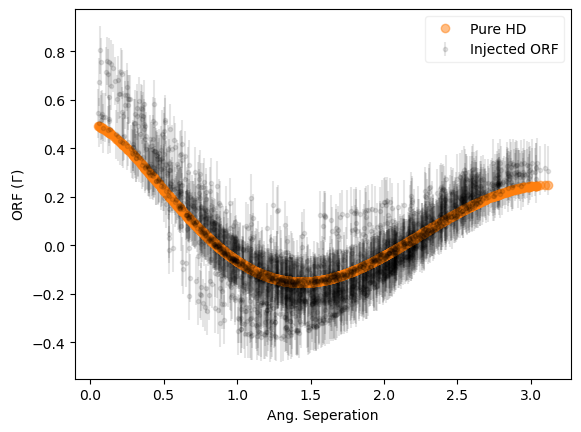

In [8]:
plt.errorbar(pta.xi, pta.injected_rho, pta.injected_sig, marker='.', color='black', alpha=0.1, ls='', label='Injected ORF')
plt.plot(pta.xi, pta.get_pure_HD(), color='tab:orange', alpha=0.5, marker='o', ls='', label='Pure HD')

plt.xlabel('Ang. Seperation')
plt.ylabel(r'ORF ($\Gamma$)')

plt.legend(framealpha=0.3)
plt.show()

## Now let's run our bayesian inference

First we supply our anis_pta object, the cross-correlation and uncertainty data we generated.

In [9]:
### Note that here pta.injected_pair_cov is None as we didn't supply it while creating the data
pta.set_data(rho=pta.injected_rho, sig=pta.injected_sig, os=1, covariance=pta.injected_pair_cov)

### Using PTMCMC sampler

First, set an output directory for ptmcmc. Then setup the ptmcmc sampler using the ```set_ptmcmc``` function.

* Note that uniform pirors for our parameters are set internally here where one can pass the min and max prior boundaries. One can access these priors with <span style="color:blue">priors</span> attribute of anis_pta object. Also, note that we can pickle the anis_pta object to the outdir for better post-processing.

* Note that here we don't run inference with bilby. To look at how to do that, refer to the ```example_linear_spherical_harmonics``` notebook.

In [10]:
### set an output directory for ptmcmc
ptmcmc_outdir = './bayes_data/sqrt_basis/ptmcmc/'

In [11]:
### Setup the ptmcmc sampler.
ptmcmc_sampler = pta.set_ptmcmc(log10_A2_prior_min=-2, log10_A2_prior_max=2,
                                bl0_prior_min=-5, bl0_prior_max=5, 
                                blm_amp_prior_min=0, blm_amp_prior_max=5, 
                                blm_phase_prior_min=0, blm_phase_prior_max=6.283185307179586,
                                outdir=ptmcmc_outdir, resume=True, save_anis_pta=True)

In [12]:
# sampler for N steps
N = int(1e6)
x0 = np.array([p.sample() for p in pta.priors])

In [13]:
### let's sample
ptmcmc_sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

Finished 0.00 percent (0.00 percent of new work) in 0.001077 s Acceptance rate = 0

/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/enterprise/signals/parameter.py:70: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 1.00 percent (1.00 percent of new work) in 5.131037 s Acceptance rate = 0.225967Adding DE jump with weight 50
Finished 100.00 percent (100.00 percent of new work) in 482.979681 s Acceptance rate = 0.217878
Run Complete


## Post-processing

#### 1. First load the data

In [91]:
### For ptmcmc run
ptmcmc_core = core.Core(chaindir=ptmcmc_outdir, burn=0.25)

### If one wants to load the pickled anis_pta object
### with open(ptmcmc_outdir+'anis_pta.pickle', 'rb') as f:
###    pta = pickle.load(f)

#### 2. Let's look at the trace-plot

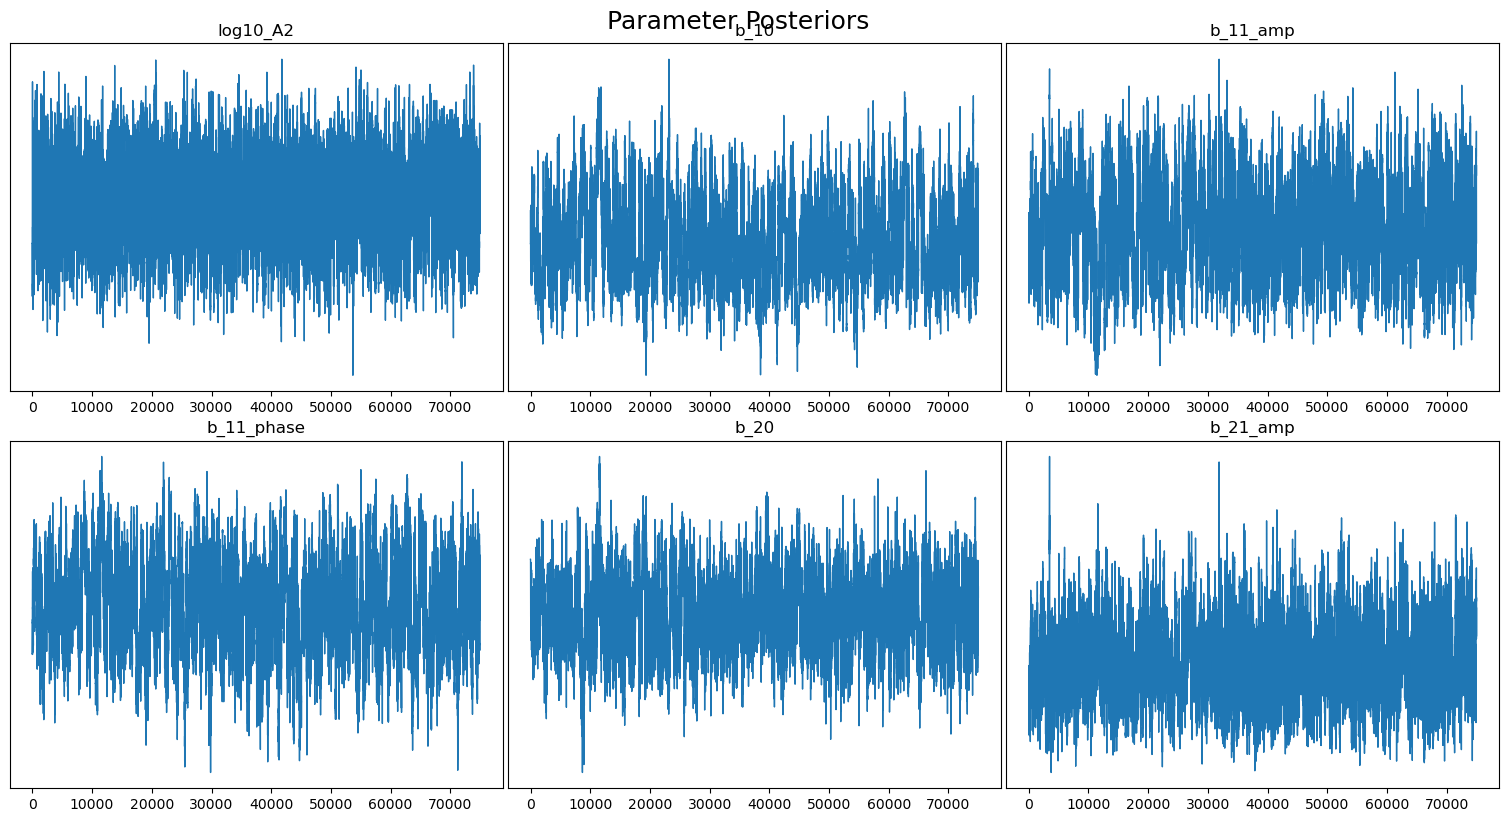

In [93]:
diagnostics.plot_chains(ptmcmc_core, hist=False, pars=pta.param_names[:6])

#### 3. Now let's look at the corner plots

In [94]:
### Get array of samples to display a corner plot
ptmcmc_corner_params = ptmcmc_core.get_param(pta.param_names)

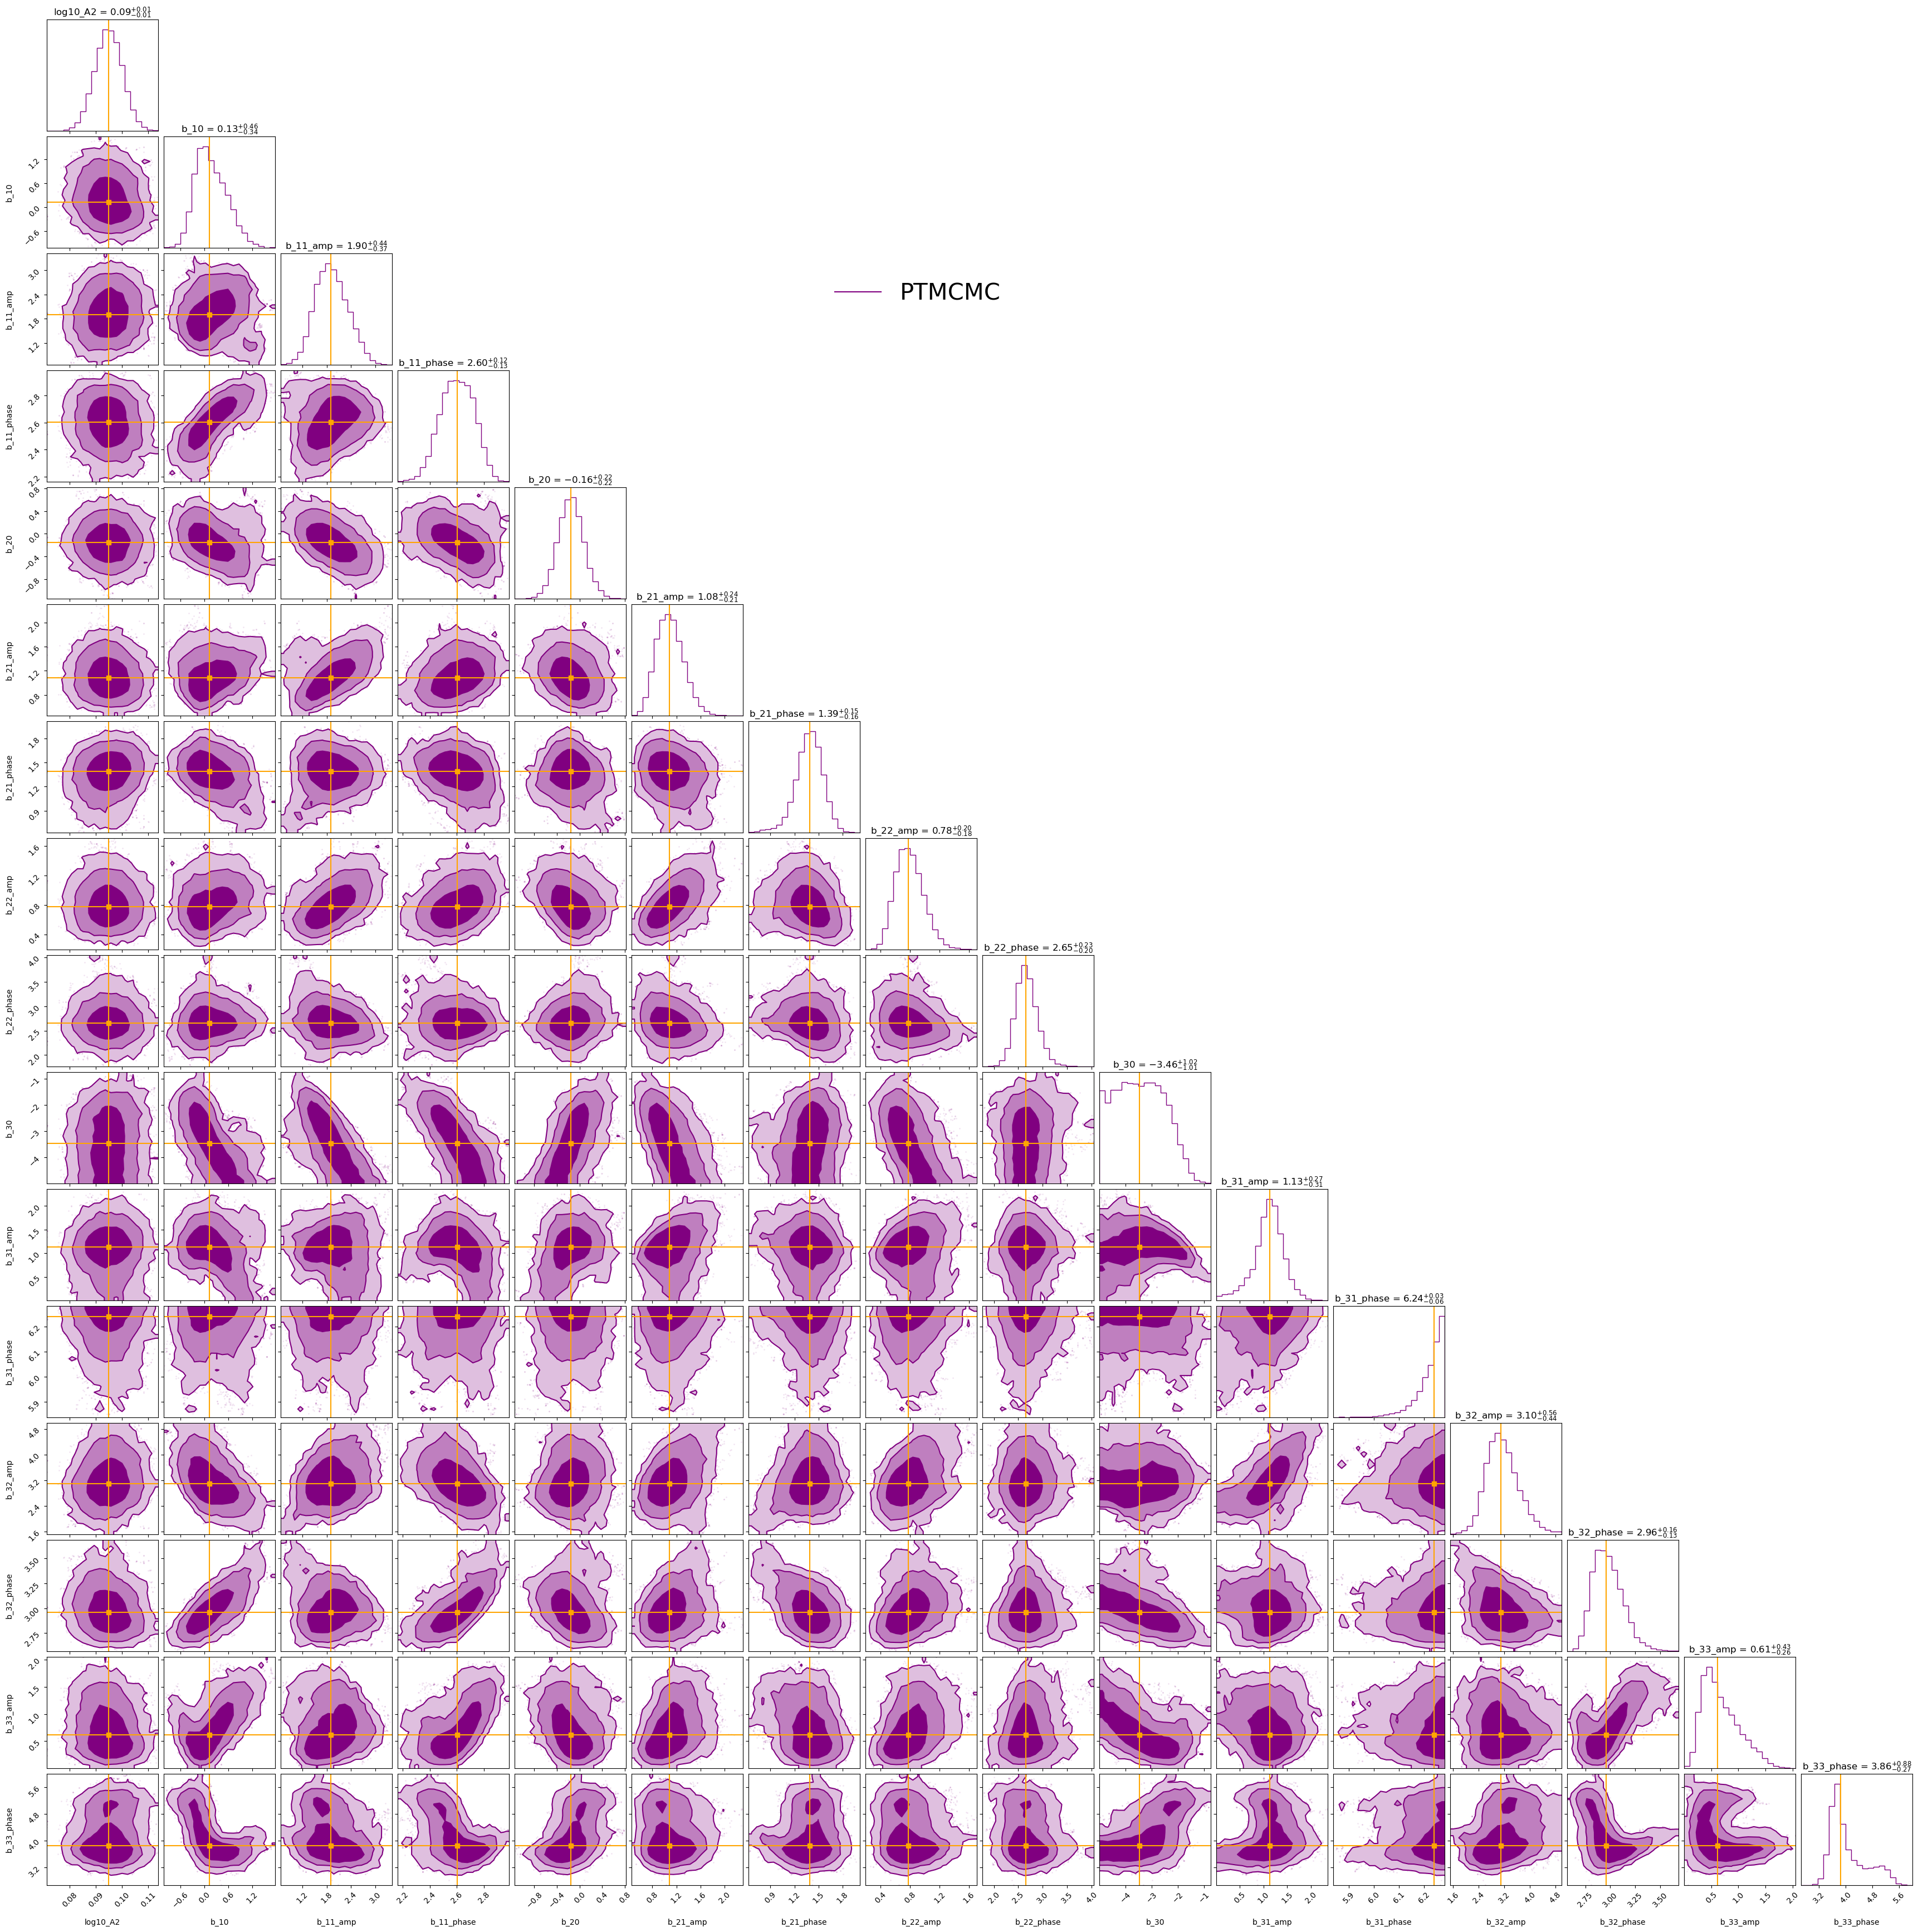

In [95]:
import matplotlib.lines as mlines

purple_line = mlines.Line2D([], [], color='purple', label=r'PTMCMC')

fig = corner.corner(ptmcmc_corner_params, plot_datapoints=True, fill_contours=True, 
                    levels=[0.6827, 0.9545, 0.997], hist_kwargs={'color' : 'purple', 'density' : True}, color='purple', 
                    show_titles=True, labels=pta.param_names, truths=ptmcmc_core.get_param_median(pta.param_names), truth_color='orange')


plt.legend(handles=[purple_line], frameon=False, bbox_to_anchor=(-8., 14., 1., .0), loc=4, fontsize=30)

plt.show()

#### 4. Recovered power-map, $C_{l}$ and ORF 

First, we need to obtain their samples using the $c_{lm}$ posterior samples. We use a handy funtion in utils to do so. ``` utils.posterior_sampled_skymap_Cl_orf(pta, data, n_draws) ``` return collection of power-maps, Cl, ORF randomly drawn from the given posteriors in data of shape ($N_{pars} \times N_{samples}$) where the number of draws are fixed by $n_{draws}$.

In [96]:
rec_pow_map, rec_Cl, rec_orf = \
utils.posterior_sampled_skymap_Cl_orf(pta, data=ptmcmc_corner_params.T, n_draws=5000)

n_draw:   0%|                                                                                                     | 0/5000 [00:00<?, ?it/s]/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/enterprise/signals/anis_coefficients.py:194: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  h = hp.alm2map(alm, nside, maxl, verbose=False)
n_draw: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:22<00:00, 60.64it/s]


Now get the median of each and plot them

In [97]:
### Get the median of power-map, Cl and orf distribution

rec_pow_map_med = [np.median(rec_pow_map[:, i]) for i in range(pta.npix)]
rec_Cl_med = [np.median(rec_Cl[:, i]) for i in range(pta.l_max+1)]
rec_orf_med = [np.median(rec_orf[:, i]) for i in range(pta.npairs)]

#### Recovered orf

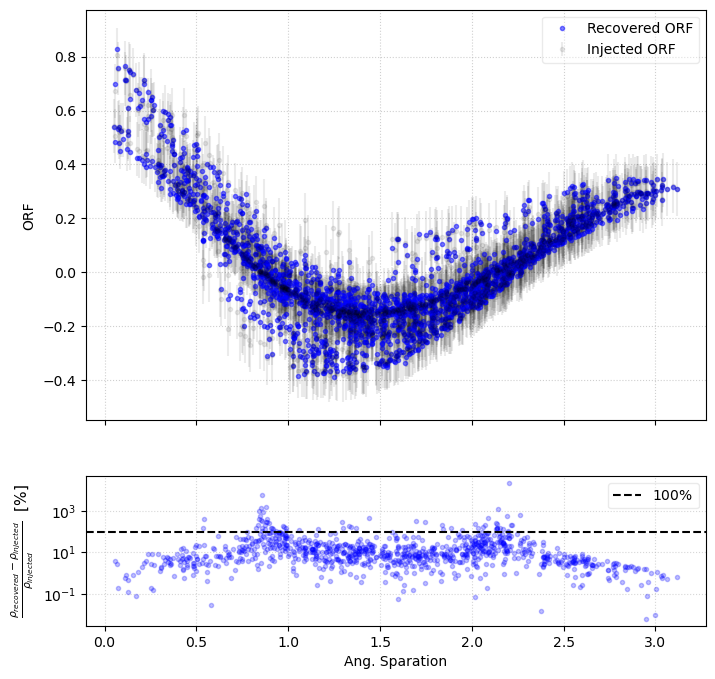

In [103]:
fig, [ax0, ax1] = plt.subplots(2, 1, figsize=(8, 8), sharex=True, height_ratios=[2.2, 0.8])


### Bilby ORF recovery
ax0.errorbar(pta.xi, pta.injected_rho, pta.injected_sig, ls='', color='black', marker='.', alpha=0.08, label='Injected ORF')
ax0.plot(pta.xi, rec_orf_med, color='blue', ls='', marker='.', alpha=0.5, label='Recovered ORF')
ax0.set_ylabel(r"ORF")
ax0.legend(framealpha=0.4)
ax0.grid(ls=':', alpha=0.6)



### Relative difference in the recovered ORF
ax1.plot(pta.xi, (rec_orf_med-pta.injected_rho)/pta.injected_rho * 100, ls='', 
             color='blue', marker='.', alpha=0.25)

ax1.axhline(100, ls='--', label=r'$100\%$', color='black')
ax1.grid(ls=':', alpha=0.5)
ax1.set_yscale('log')
ax1.legend(framealpha=0.4, ncol=3)
ax1.set_ylabel(r'$\frac{\rho_{recovered} - \rho_{injected}}{\rho_{injected}}$  $[\%]$', fontsize=11)
ax1.set_xlabel(r'Ang. Sparation')



plt.show()

#### Recovered $C_{l}$

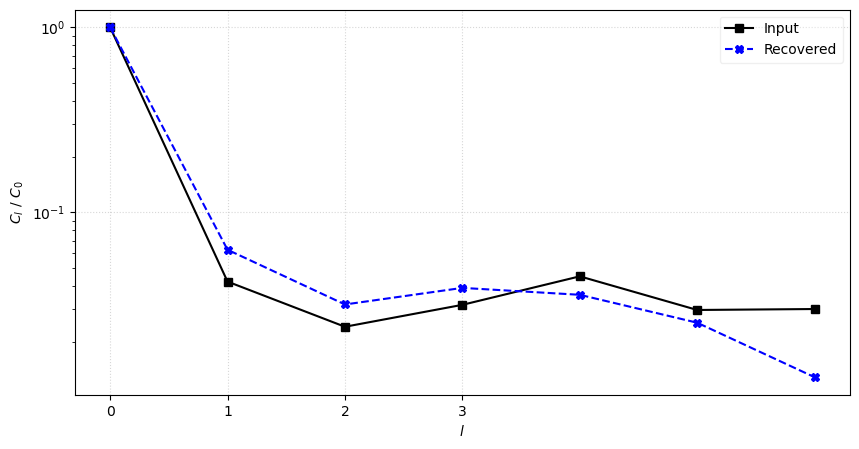

In [102]:
plt.figure(figsize=(10, 5))

plt.plot(range(pta.l_max+1), pta.injected_Cl/pta.injected_Cl[0], color='black', marker='s', label='Input')
plt.plot(range(pta.l_max+1), rec_Cl_med/rec_Cl_med[0], color='blue', ls ='--', marker='X', label='Recovered')

plt.xlabel(r'$l$')
plt.ylabel(r'$C_{l} \ / \ C_{0}$')

plt.yscale('log')
plt.xticks([0.0, 1.0, 2.0, 3.0])

plt.legend(framealpha=0.3)
plt.grid(ls=':', alpha=0.5)
plt.show()

#### Recovered power-map

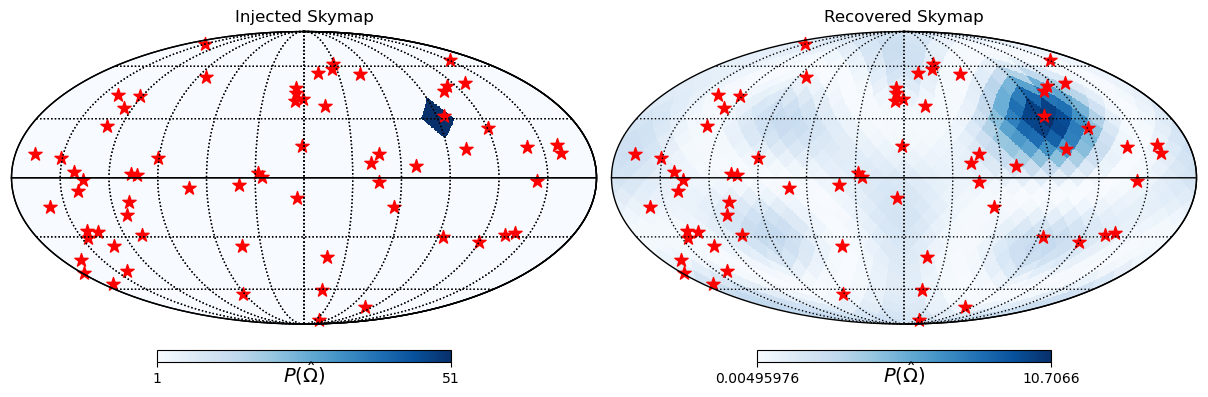

In [101]:
plt.figure(figsize=(12, 5))

hp.mollview(pta.injected_power, sub=(1, 2, 1), title = 'Injected Skymap',cmap='Blues', 
            unit='$P(\hat\Omega)$', rot=180)
hp.graticule()

hp.mollview(np.array(rec_pow_map_med), sub=(1, 2, 2), title = 'Recovered Skymap',cmap='Blues', 
            unit='$P(\hat\Omega)$', rot=180)
hp.graticule()

hp.projscatter(pta.psrs_theta, pta.psrs_phi, color = 'red', marker = '*', s = 100)
plt.show()